<a href="https://colab.research.google.com/github/2303A51689/Application-of-Data-Mining/blob/main/Decision_Tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

df = pd.read_csv('/content/titanic.csv')

# We'll pick a few important features for simplicity
df = df[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Embarked']]

# Handle missing values
df['Age'].fillna(df['Age'].median(), inplace=True)
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# Label Encoding for categorical variables
le = LabelEncoder()
df['Sex'] = le.fit_transform(df['Sex'])
df['Embarked'] = le.fit_transform(df['Embarked'])

X = df.drop(columns=['Survived'])
y = df['Survived']

# Combine into one for our ID3
df = X.copy()
df['Survived'] = y

print("📋 Preprocessed Titanic Dataset:")
print(df.head())


📋 Preprocessed Titanic Dataset:
   Pclass  Sex   Age  SibSp  Parch  Embarked  Survived
0       3    1  22.0      1      0         2         0
1       1    0  38.0      1      0         0         1
2       3    0  26.0      0      0         2         1
3       1    0  35.0      1      0         2         1
4       3    1  35.0      0      0         2         0


<ipython-input-6-4034381447c1>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
<ipython-input-6-4034381447c1>:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try us

In [2]:
# Entropy Function
def entropy(target_col):
    elements, counts = np.unique(target_col, return_counts=True)
    entropy = 0
    for i in range(len(elements)):
        probability = counts[i] / np.sum(counts)
        entropy -= probability * np.log2(probability)
    return entropy

# Information Gain Function
def information_gain(data, split_attribute_name, target_name="Survived"):
    total_entropy = entropy(data[target_name])
    vals, counts = np.unique(data[split_attribute_name], return_counts=True)

    weighted_entropy = 0
    for i in range(len(vals)):
        subset = data[data[split_attribute_name] == vals[i]]
        weighted_entropy += (counts[i] / np.sum(counts)) * entropy(subset[target_name])

    information_gain = total_entropy - weighted_entropy
    return information_gain


In [7]:
# ID3 Algorithm
def ID3(data, original_data, features, target_attribute_name="Survived", parent_node_class=None):
    # If all target_values have the same value, return that value
    if len(np.unique(data[target_attribute_name])) <= 1:
        return np.unique(data[target_attribute_name])[0]

    # If the dataset is empty
    elif len(data) == 0:
        return np.unique(original_data[target_attribute_name])[np.argmax(np.unique(original_data[target_attribute_name], return_counts=True)[1])]

    # If no more features
    elif len(features) == 0:
        return parent_node_class

    else:
        # Set the default value
        parent_node_class = np.unique(data[target_attribute_name])[np.argmax(np.unique(data[target_attribute_name], return_counts=True)[1])]

        # Select best feature
        item_values = [information_gain(data, feature, target_attribute_name) for feature in features]
        best_feature_index = np.argmax(item_values)
        best_feature = features[best_feature_index]

        tree = {best_feature: {}}

        features = [i for i in features if i != best_feature]

        for value in np.unique(data[best_feature]):
            sub_data = data.where(data[best_feature] == value).dropna()
            subtree = ID3(sub_data, original_data, features, target_attribute_name, parent_node_class)
            tree[best_feature][value] = subtree

        return tree

# Build the tree
features = list(df.columns)
features.remove('Survived')

tree = ID3(df, df, features)
print("\n Decision Tree:")
print(tree)



 Decision Tree:
{'Sex': {np.int64(0): {'Age': {np.float64(0.75): np.float64(1.0), np.float64(1.0): np.float64(1.0), np.float64(2.0): {'Parch': {np.float64(1.0): {'Pclass': {np.float64(2.0): np.float64(1.0), np.float64(3.0): {'SibSp': {np.float64(0.0): {'Embarked': {np.float64(2.0): np.float64(0.0)}}}}}}, np.float64(2.0): np.float64(0.0)}}, np.float64(3.0): {'Pclass': {np.float64(2.0): np.float64(1.0), np.float64(3.0): np.float64(0.0)}}, np.float64(4.0): np.float64(1.0), np.float64(5.0): np.float64(1.0), np.float64(6.0): {'Pclass': {np.float64(2.0): np.float64(1.0), np.float64(3.0): np.float64(0.0)}}, np.float64(7.0): np.float64(1.0), np.float64(8.0): {'Pclass': {np.float64(2.0): np.float64(1.0), np.float64(3.0): np.float64(0.0)}}, np.float64(9.0): np.float64(0.0), np.float64(10.0): np.float64(0.0), np.float64(11.0): np.float64(0.0), np.float64(13.0): np.float64(1.0), np.float64(14.0): {'SibSp': {np.float64(0.0): np.float64(0.0), np.float64(1.0): np.float64(1.0)}}, np.float64(14.5): np

In [8]:
# Prediction Function
def predict(query, tree, default=1):
    for feature in query.keys():
        if feature in tree.keys():
            try:
                result = tree[feature][query[feature]]
            except:
                return default

            if isinstance(result, dict):
                return predict(query, result)
            else:
                return result
    return default

test_samples = X.sample(3)
print("\nTest Samples:\n", test_samples)

predictions = []
for i in range(len(test_samples)):
    query = test_samples.iloc[i].to_dict()
    prediction = predict(query, tree)
    predictions.append(prediction)

print("\n📋 Predictions on test samples:", predictions)



Test Samples:
      Pclass  Sex   Age  SibSp  Parch  Embarked
680       3    0  28.0      0      0         1
225       3    1  22.0      0      0         2
122       2    1  32.5      1      0         0

📋 Predictions on test samples: [np.float64(1.0), np.float64(0.0), np.float64(0.0)]



 Decision Tree Accuracy: 0.7313432835820896


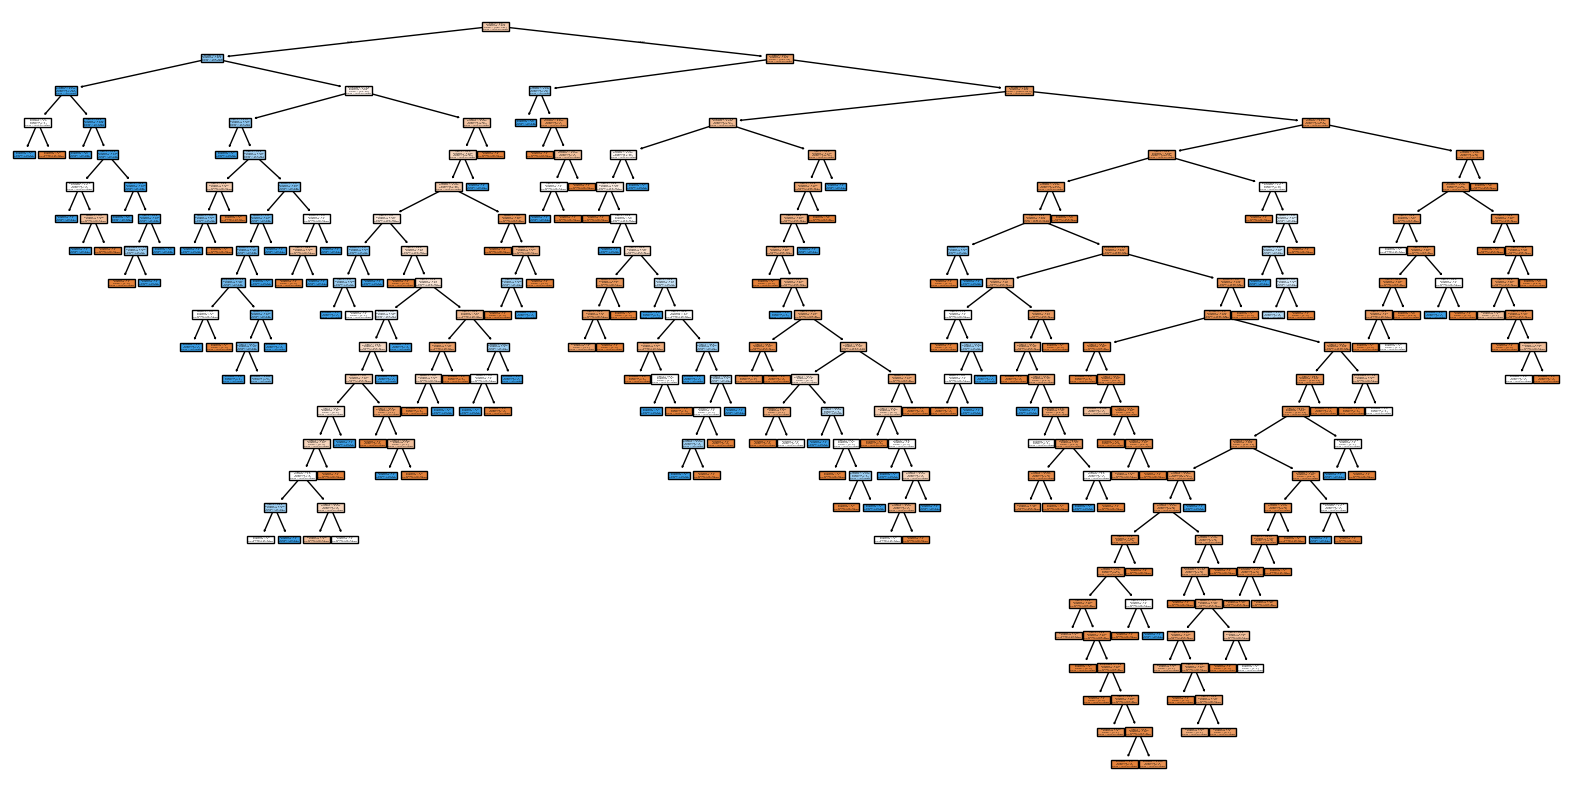

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

clf = DecisionTreeClassifier(criterion='entropy')
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("\n Decision Tree Accuracy:", accuracy)

plt.figure(figsize=(20,10))
plot_tree(clf, feature_names=X.columns, class_names=["Not Survived", "Survived"], filled=True)
plt.show()
